In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import uproot as up

/hpc/applications/anaconda/3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
branch_names=['lep_Pt_0','lep_Pt_1','lep_Pt_2',
              'Ptll01',
              'met_met','Mll01','Mll12','best_Z_Mll',
              'DRll01','DRll02','DRll12',
              'HT','HT_lep',
              'DRl2j0','DRl2j1',
              'mj0j1','ml0j0','ml0j1','ml2j0','ml2j1']



signal_events = up.open("signal.root")['nominal']
vv_events = up.open("vv.root")['nominal']

df_signal = signal_events.pandas.df(branch_names)
df_vv    = vv_events.pandas.df(branch_names)

df_signal['class'] =1
df_vv['class']=0


print("Total Signal events: ",len(df_signal))
print("Total VV events: ",len(df_vv))

df = df_signal.append(df_vv)
df = df.sample(frac=1).reset_index(drop=True) # Sort 

y_df = df.pop('class')

Total Signal events:  26915
Total VV events:  423395


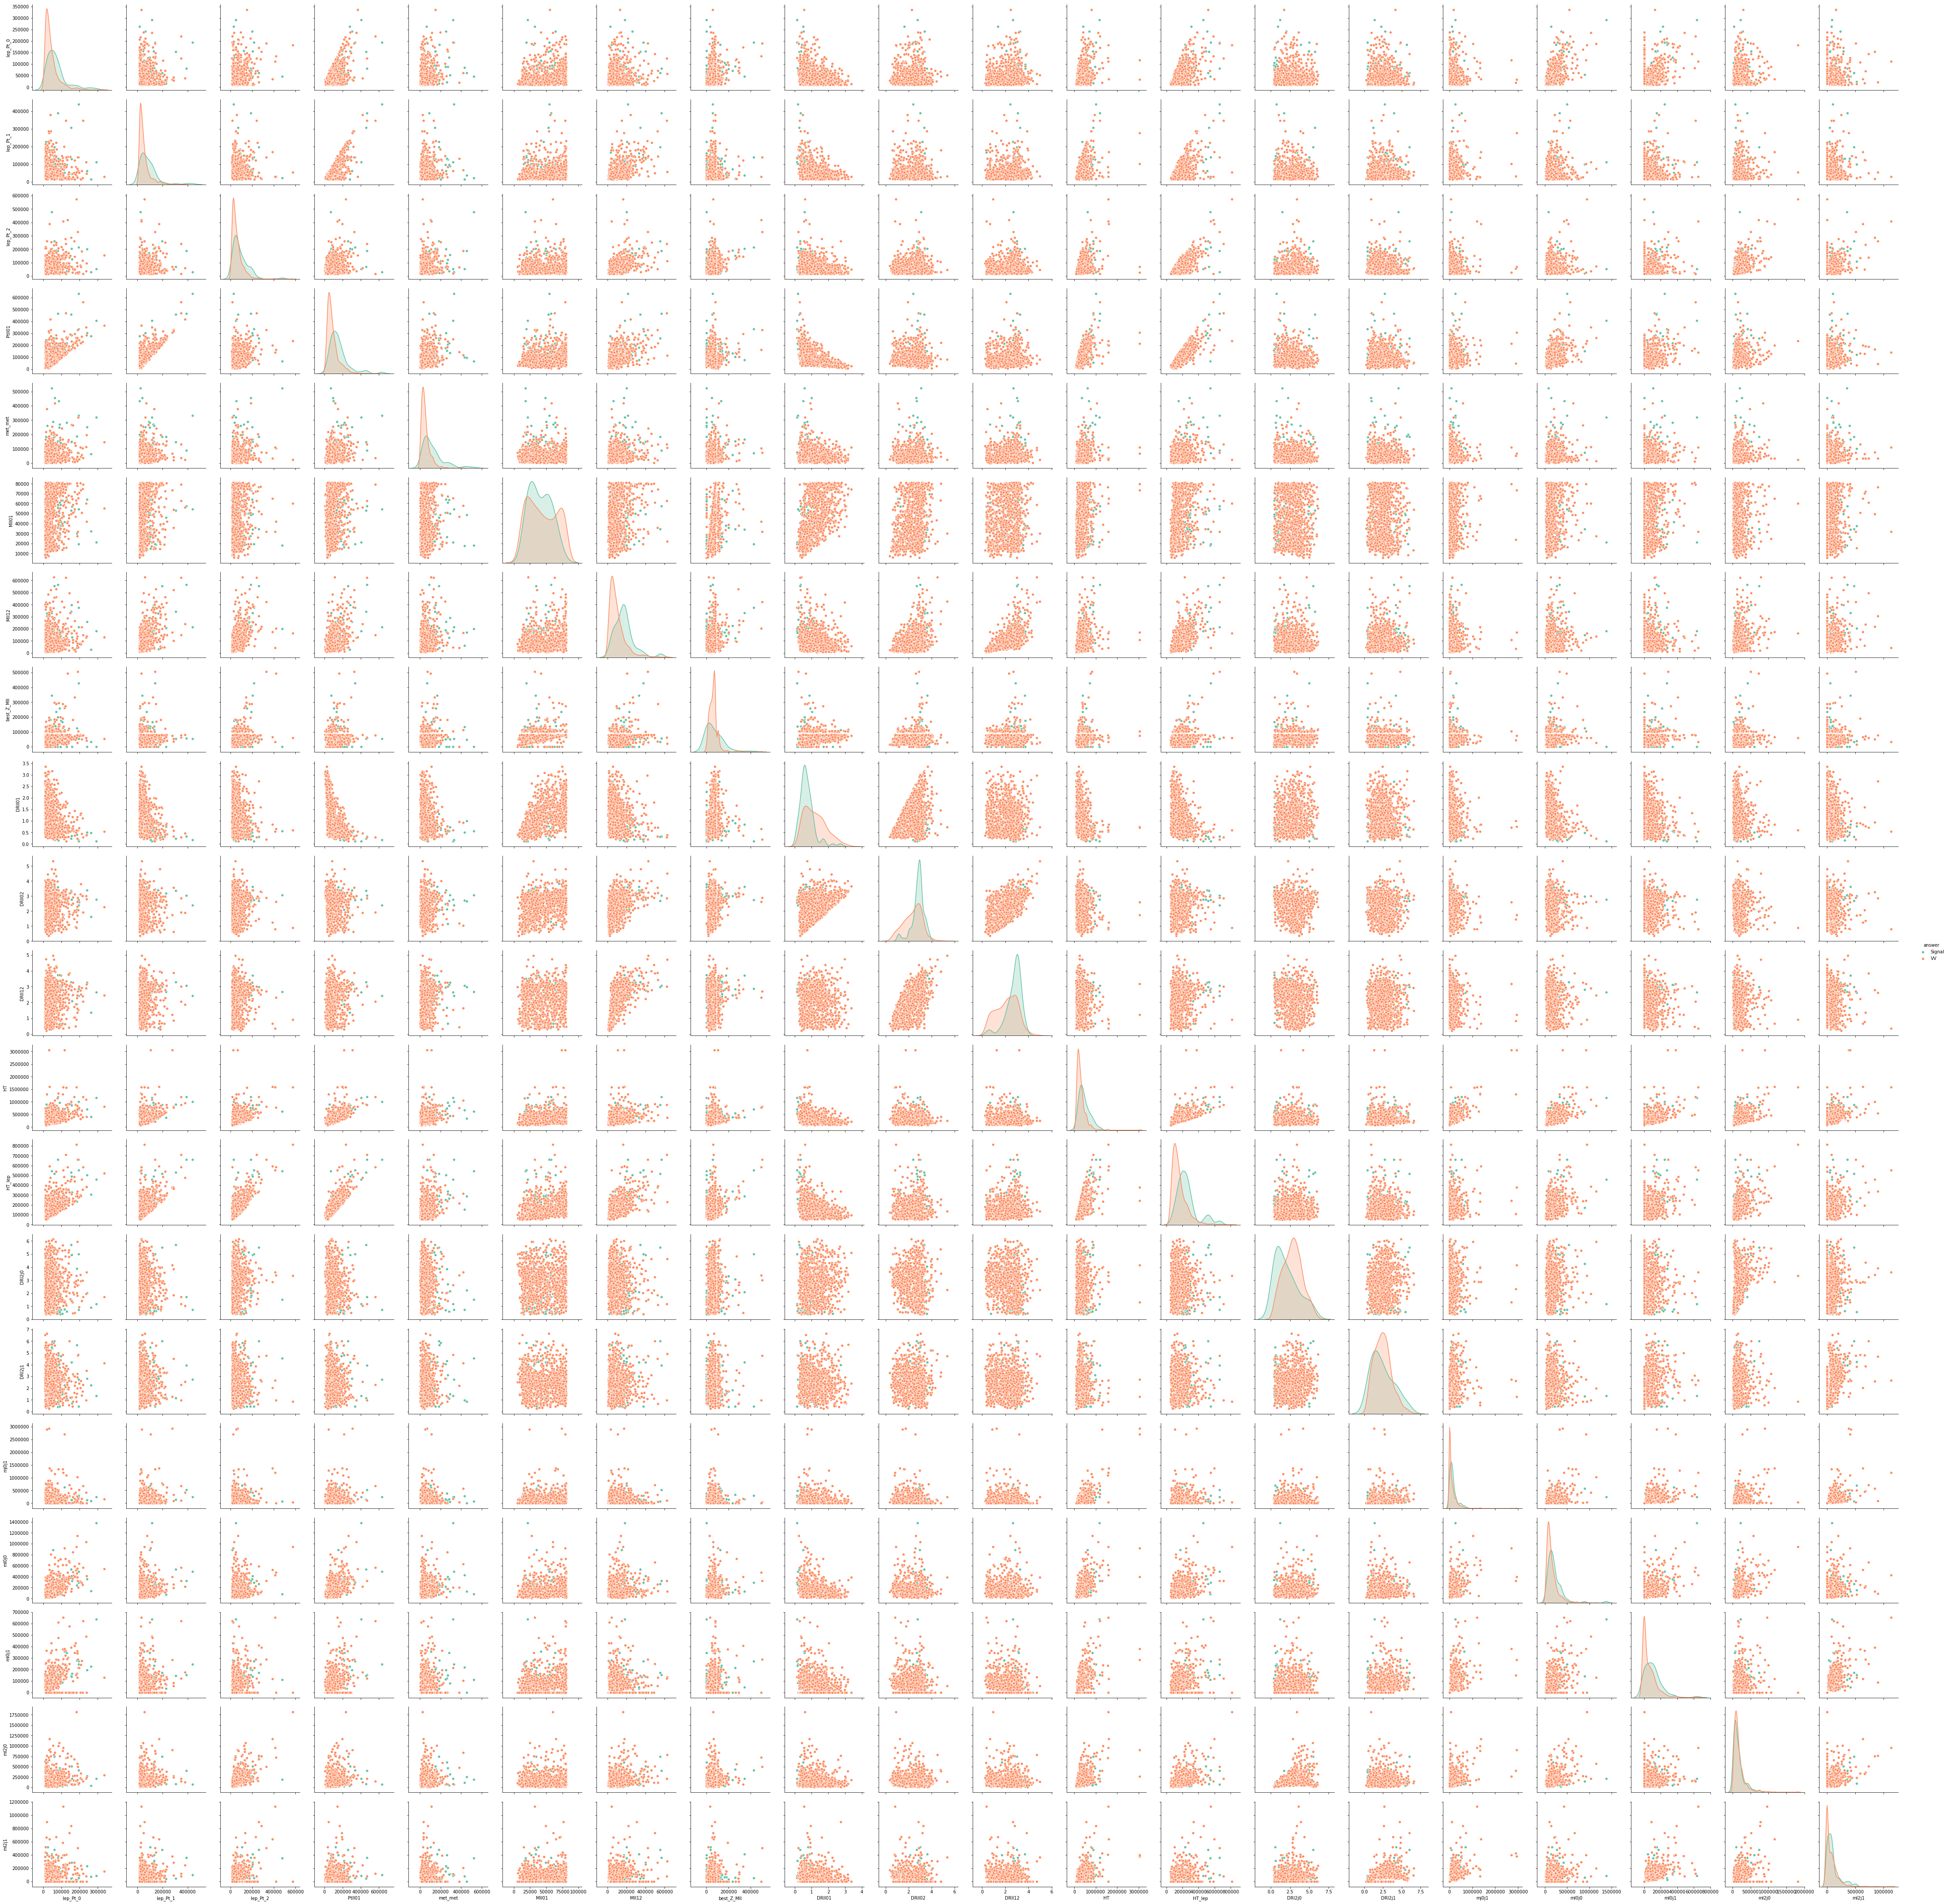

In [5]:
import seaborn as sns
# Seaborn is a nice package for data visualization - it has many pre-defined plotting functions and looks pretty

# Only keep some variables for training
variable_names = branch_names

# Make a new column where the answer is a category with the appropriate name, for plotting
#df['answer']='VV'
df.loc[y_df==1,'answer']='Signal'
df.loc[y_df==0,'answer']='VV'
#df.loc[y_df==2,'answer']='VV'
df['answer'] = df['answer'].astype('category')

# Plot input distributions and visualize correlations; only look at a subset of events for scatter plotting
g = sns.pairplot(df.head(1000), vars=variable_names, hue='answer', palette="Set2", height=3)

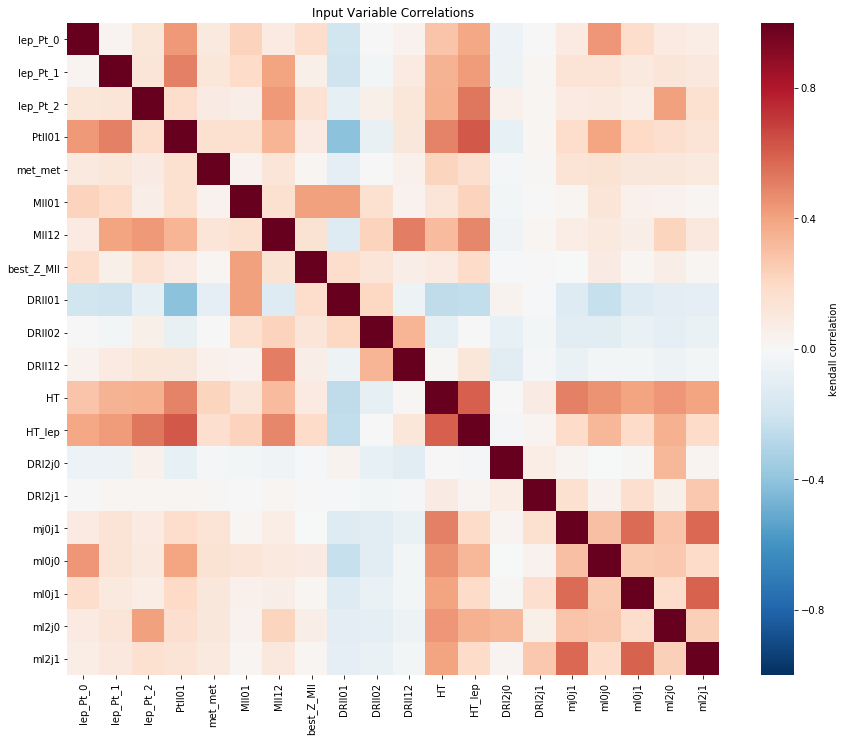

In [6]:
# Show correlation coefficients across variables
# Different correlation coefficients compared here: https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall
# Generically, Kendall only requires a monotonic relationship (not linear) and is more robust to outliers, as it only uses rank information (quantiles)
# Pearson includes a bit more information but assumes normal distributions and linear relationships
#method = 'pearson'
method = 'kendall'
correlations = df[variable_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (15,12))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

In [3]:
#Split the samples into test and train.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score


X_train,X_test,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.2,random_state=0)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
##applying weights for unbalanced samples

def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

In [5]:
largest_class_weight_coef = max(y_df.value_counts().values)/df.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
#weight

In [6]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, weight)
#clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
#clf.save_model('vvonly_bdt_nohpop.xgb')

In [7]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm


array([[76471,  8354],
       [  949,  4288]])

In [8]:
ac = accuracy_score(y_test,y_pred)*100
ac

89.67044924607492

In [10]:
#from sklearn.model_selection import cross_val_score
#XGB_accuracies = cross_val_score(estimator = clf, X = df[branch_names], y = y_df, cv = 10)
#print("Mean_XGB_Acc : ", XGB_accuracies.mean())

<Figure size 432x288 with 0 Axes>

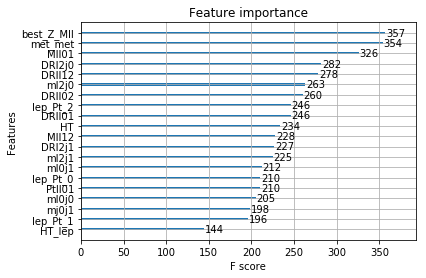

In [11]:
y_pred = clf.predict(X_test)
fig = plt.figure()
xgb.plot_importance(clf)#, ax=plt.gca())
fig.subplots_adjust(left=0.4)

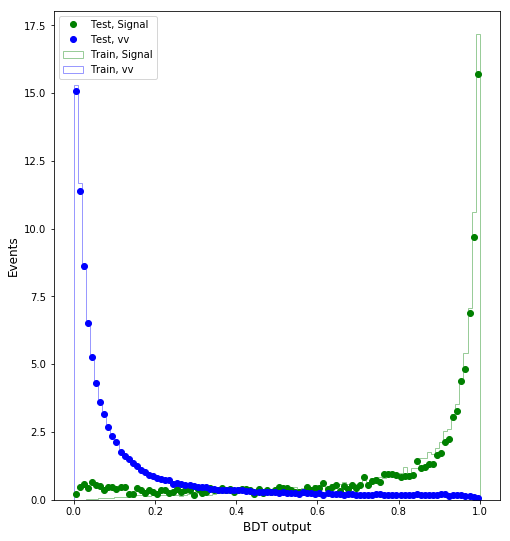

In [12]:
y_pred_DD_train = clf.predict_proba(X_train[y_train==1])
y_pred_DD_test = clf.predict_proba(X_test[y_test==1])
#y_pred_ch3t_train = clf.predict_proba(X_train[y_train==0])
#y_pred_ch3t_test = clf.predict_proba(X_test[y_test==0])
y_pred_vv_train = clf.predict_proba(X_train[y_train==0])
y_pred_vv_test = clf.predict_proba(X_test[y_test==0])


n_bins=100
hist_range=(0,1.0)
plt.figure(figsize=(8,9))

plt.hist(y_pred_DD_train[:,1],bins=n_bins,range=hist_range,histtype='step' , color="green",density=True,alpha=0.4,label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test[:,1], bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="green",label="Test, Signal")

#plt.hist(y_pred_ch3t_train[:,0],bins=n_bins,range=hist_range,histtype='step',density=True,alpha=0.4,color="red",label="Train, ttbar")
#counts,bin_edges = np.histogram(y_pred_ch3t_test[:,0], bins=n_bins,range=hist_range,density=True)
#bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#plt.plot(bin_centers, counts,marker="o",linestyle="None",color="red",label="Test, ttbar")

plt.hist(y_pred_vv_train[:,1],bins=n_bins,range=hist_range,histtype='step',density=True,alpha=0.4,color="blue",label="Train, vv")
counts,bin_edges = np.histogram(y_pred_vv_test[:,1],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="blue",label="Test, vv")

plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events",fontsize=12)
plt.legend()
plt.xlabel('BDT output')
plt.show()


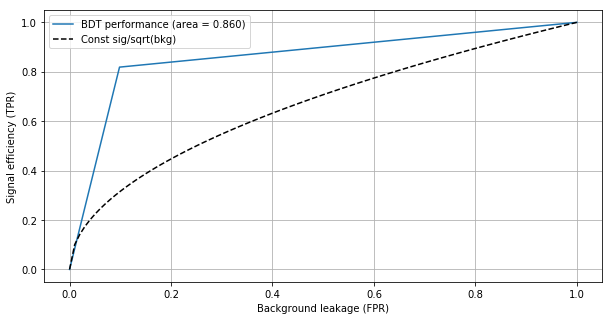

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
y_pred = clf.predict(X_test)

# Use the test data, since the training data can "cheat" by overfitting
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_pred, pos_label=1) # Signal class set to 1
auc0 = auc(BDT_FPR_test,BDT_TPR_test)

plt.figure(figsize=(10,5))
plt.plot(BDT_FPR_test, BDT_TPR_test, label='BDT performance (area = {:.3f})'.format(auc0))
#plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

n_pts = 100
bkg_eff = np.linspace(0,1,n_pts)
sig_fixed = np.sqrt(bkg_eff)
plt.plot(bkg_eff, sig_fixed, label="Const sig/sqrt(bkg)", color='black', linestyle='--')
plt.grid(True, which="both")
plt.legend()
plt.show()



In [14]:
#Hyper parameter optimization
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        #'n_estimators': 100,
        'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
        'objective':hp.choice('objective',['multi:softprob','multi:softmax']),
        #'objective':hp.choice('objective',['binary:logistic','binary:hinge']),
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(num_class=2,
                    objective= space['objective'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),tree_method='gpu_hist')
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,eval_metric="merror",
            #early_stopping_rounds=10, nfold=3,verbose=False)
            early_stopping_rounds=5 ,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest, max_evals = 100,trials = trials)

In [ ]:
best_hyperparams

In [ ]:
best_hyperparams['num_class'] = 2
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['n_estimators'] = int (best_hyperparams['n_estimators'])
best_hyperparams['tree_method'] = 'gpu_hist'
best_hyperparams['objective'] = "multi:softprob"
#best_hyperparams['objective'] = "binary:logistic"
clf_opt = xgb.XGBClassifier(**best_hyperparams)
xbgm = clf_opt.fit(X_train, y_train, weight)
#clf_opt.save_model('vvonly_bdt.xgb')
xbgm

In [ ]:
from sklearn.model_selection import cross_val_score
XGB_accuracies = cross_val_score(estimator = clf_opt, X = df[branch_names], y = y_df, cv = 10)
print("Mean_XGB_Acc : ", XGB_accuracies.mean())

In [ ]:
clf_opt.save_model('vvonly_bdt.xgb')

In [ ]:
y_pred_opt = clf_opt.predict(X_test)
y_pred_prob_opt = clf_opt.predict_proba(X_test)
y_pred_prob_opt

In [ ]:
y_pred_DD_train = clf_opt.predict_proba(X_train[y_train==1])
y_pred_DD_test = clf_opt.predict_proba(X_test[y_test==1])
y_pred_vv_train = clf_opt.predict_proba(X_train[y_train==0])
y_pred_vv_test = clf_opt.predict_proba(X_test[y_test==0])


n_bins=80
hist_range=(0.0,1.0)
#DD_color = sns.color_palette("Set2")[1]
#CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(8,9))
plt.hist(y_pred_DD_train[:,1],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="green",label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test[:,1],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#menStd     = np.sqrt(counts)
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
#plt.errorbar(x=0, xerr =0,y=counts, yerr=menStd)
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="green",label="Test, Signal")


plt.hist(y_pred_vv_train[:,1],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="red",label="Train, VV")
counts,bin_edges = np.histogram(y_pred_vv_test[:,1],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="red",label="Test, VV")



plt.legend()
plt.xlabel('BDT output')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score

# Use the test data, since the training data can "cheat" by overfitting
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_pred_opt, pos_label=1) # Signal class set to 1
auc0 = auc(BDT_FPR_test,BDT_TPR_test)

plt.figure(figsize=(10,5))
plt.plot(BDT_FPR_test, BDT_TPR_test, label='BDT performance (area = {:.3f})'.format(auc0))
#plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

n_pts = 100
bkg_eff = np.linspace(0,1,n_pts)
sig_fixed = np.sqrt(bkg_eff)
plt.plot(bkg_eff, sig_fixed, label="Const sig/sqrt(bkg)", color='black', linestyle='--')
plt.grid(True, which="both")
plt.legend()
plt.show()

In [ ]:
ac = accuracy_score(y_test,y_pred_opt)*100
ac

In [ ]:
fig = plt.figure()
xgb.plot_importance(clf_opt)#, ax=plt.gca())
fig.subplots_adjust(left=0.4)